In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
senti = pd.read_json("../graph_network/full_data_iv_29-04-24.json")
s = pd.read_json("../sentiment-analyser/saiv_28-04-24.json") 
# s = s.drop_duplicates(subset=['text', "negative", "neutral", "positive"])


In [2]:
def save_as_json(pandas_dataframe, file_name):
    import datetime
    date_info = datetime.datetime.now().strftime("%d-%m-%y")
    pandas_dataframe.to_json(f"{file_name}_{date_info}.json", orient='records')


def get_mean_coefficients_per_cluster(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    for i in range(df[cluster_col].unique().shape[0]):
        count = df.loc[df[cluster_col]==i].shape[0]
        print(f"Cluster Nr. {i}; Total Pages in Cluster: {count}")
        for coeff in coefficient_names:
            print(f"avg {coeff}:", round(df.loc[df[cluster_col]==i, coeff].mean(), 5))
        print()
        

def get_color(input_vector):
    import numpy as np
    red = np.array([1, 0, 0])
    yellow = np.array([1, 1, 0])
    green = np.array([0, 1, 0])
    rgb = input_vector[0] * red + input_vector[1] * yellow + input_vector[2] * green
    color = "#" + "".join(f"{int(x*255):02x}" for x in rgb)
    return color


def add_color_column_of_df_to_matrix(dataframe, cluster_column, new_col_names):
    dataframe[f"color_{cluster_column}"] = (
        dataframe[new_col_names]
        .apply(lambda row: np.array(row), axis=1)
        .apply(lambda row: get_color(row))
    )
    # result = pd.merge(matrix, dataframe[["url", "color"]], how="left", on=["url"])
    return dataframe

def get_cluster_average_color(df, cluster_column, columns_to_average):
    new_col_names=[]
    for col in columns_to_average:
        average_col_name = f"m_{col}"  # Erzeuge Namen für die neuen Durchschnittsspalten
        df[average_col_name] = df.groupby(cluster_column)[col].transform('mean')
        new_col_names.append(average_col_name)
    df = add_color_column_of_df_to_matrix(df, cluster_column, new_col_names)
    for average_col_name in new_col_names:
        df.drop(average_col_name, axis=1, inplace=True)
    return df

def get_mean_sentiment_coefficients_of_neighbours(pandas_dataframe):
    coefficient_names = ["negative", "neutral", "positive"]
    for coefficient in coefficient_names:
        results = []
        result_dataframe = pandas_dataframe
        all_urls = pandas_dataframe.url.tolist()
        for url in all_urls:
            idx = all_urls.index(url)
            linkedpages_per_url = pandas_dataframe.at[idx, "linkedpages"]
            mean_of_neighbours = pandas_dataframe.loc[pandas_dataframe["url"].isin(linkedpages_per_url), coefficient].mean()
            results.append(round(mean_of_neighbours, 5))
        pandas_dataframe.insert(loc=len(pandas_dataframe.columns), column=f"avg_{coefficient}", value=results)
    return pandas_dataframe


def append_cluster_color(df, cluster_col):
    num_of_clusters = df[cluster_col].nunique()
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / num_of_clusters) for i in range(num_of_clusters)]
    df[f'color_{cluster_col}'] = df[cluster_col].apply(lambda x: colors[x % num_of_clusters])

def get_cluster_plot(pandas_df, cluster_col):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    color_col = f"color_{cluster_col}"
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pandas_df['negative'], pandas_df['neutral'], pandas_df['positive'], c=pandas_df[color_col])
    ax.set_xlabel('Negative')
    ax.set_ylabel('Neutral')
    ax.set_zlabel('Positive')
    plt.show()

In [9]:
senti

,url,pagetitle,text,linkedpages,negative,neutral,positive,color,cluster
0,https://www.mobiliar.ch,Versicherungen & Vorsorge,Versicherungen & Vorsorge,[https://www.mobiliar.ch/versicherungen-und-vo...,0.230486,0.140164,0.629349,#5ec400,0
1,https://www.mobiliar.ch/versicherungen-und-vor...,Tierversicherung,Tierversicherung Hunde und Katzen versichern D...,"[https://www.mobiliar.ch/, https://www.mobilia...",0.458895,0.168780,0.372325,#a08900,1
2,https://www.mobiliar.ch/versicherungen-und-vor...,Cyberversicherung,Cyberversicherung Hilfe im digitalen Alltag Ba...,"[https://www.mobiliar.ch/, https://www.mobilia...",0.431041,0.155108,0.413851,#959100,1
3,https://www.mobiliar.ch/versicherungen-und-vor...,Wohnen & Eigentum,Wohnen & Eigentum,"[https://www.mobiliar.ch/, https://www.mobilia...",0.208000,0.195661,0.596339,#66c900,0
4,https://www.mobiliar.ch/versicherungen-und-vor...,Mietkautionsversicherung,Mietkautionsversicherung Dank einer Mietkautio...,"[https://www.mobiliar.ch/, https://www.mobilia...",0.338874,0.185144,0.475982,#85a800,1
...,...,...,...,...,...,...,...,...,...
1739,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Wir befähigen für die Zukunft,Wir befähigen für die Zukunft Von der Idee zur...,"[https://www.mobiliar.ch/die-mobiliar, https:/...",0.228822,0.119091,0.652087,#58c400,0
1740,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Wir denken Zukunft,Wir denken Zukunft Erfahrungen und Erkenntniss...,"[https://www.mobiliar.ch/die-mobiliar, https:/...",0.181774,0.126676,0.691551,#4ed000,2
1741,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Leitbild der Gruppe Mobiliar,Leitbild der Gruppe Mobiliar \n\tDas Leitbild...,"[https://www.mobiliar.ch/die-mobiliar, https:/...",0.245275,0.097418,0.657307,#57c000,0
1742,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Geisterhaus-Spot gewinnt Silber-Edi.,Geisterhaus-Spot gewinnt Silber-Edi. \n\tAusz...,"[https://www.mobiliar.ch/die-mobiliar, https:/...",0.337304,0.129163,0.533533,#76a800,0


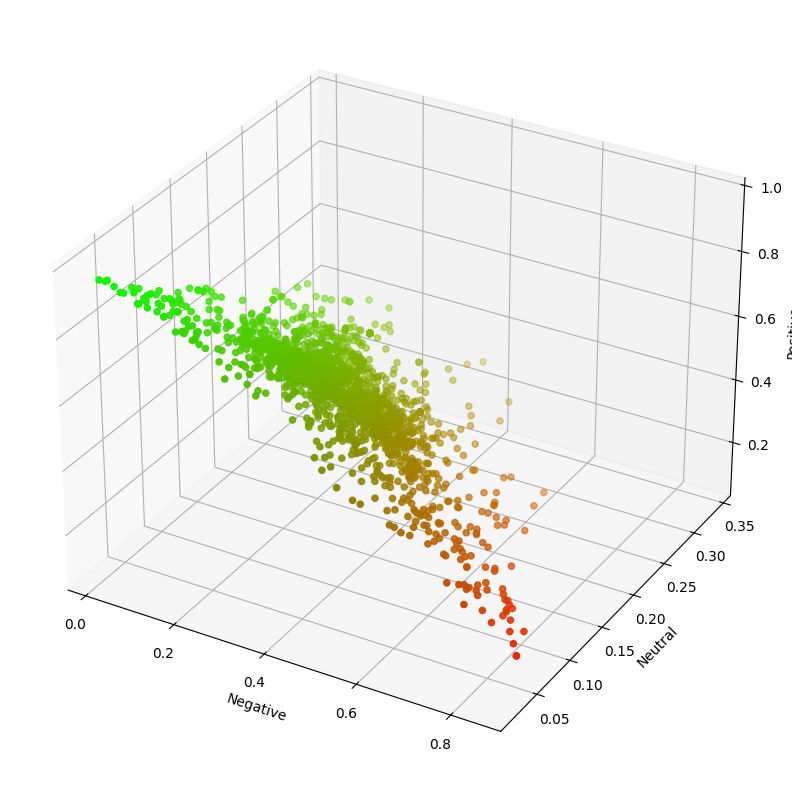

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Erstellen einer neuen Figur
fig = plt.figure(figsize=(10, 10))

# Hinzufügen eines 3D-Subplots
ax = fig.add_subplot(111, projection='3d')

# Daten für jede Achse
x = senti["negative"]
y = senti["neutral"]
z = senti["positive"]
color = senti["color"]
# Plotten der Daten
ax.scatter3D(x, y, z, c=color)
# Beschriftung der Achsen
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
ax.set_zlabel('Positive')
# Anzeigen des Plots
plt.show()


In [ ]:
# XY-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
plt.title('2D Plot - XY Plane')
plt.show()

# XZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, z, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Positive')
plt.title('2D Plot - XZ Plane')
plt.show()

# YZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y, z, c=color)
ax.set_xlabel('Neutral')
ax.set_ylabel('Positive')
plt.title('2D Plot - YZ Plane')
plt.show()


# Clustering
## K-Means

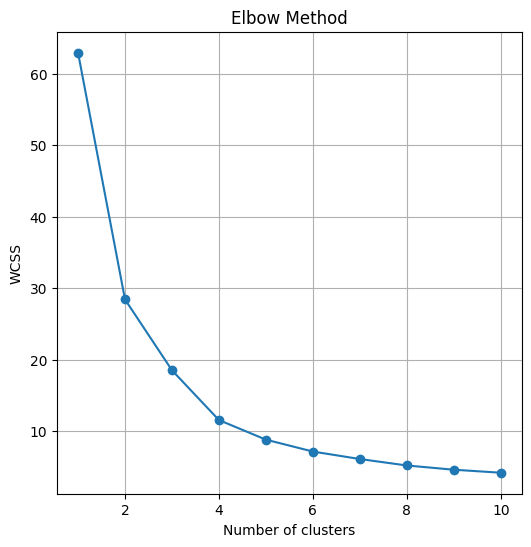

In [151]:
from sklearn.cluster import KMeans

# Liste, um die WCSS für jedes k zu speichern
wcss = []

# Berechnen des WCSS für verschiedene Werte von k (z.B. von 1 bis 10)
for i in range(1, 11):  # Ändern Sie 11 je nach Bedarf für größere k
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(senti[['negative','neutral', 'positive']])
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt

# Erstellen eines Plots
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o')  # Passen Sie den Bereich entsprechend an
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [195]:
import pandas as pd
from sklearn.cluster import KMeans

# Angenommen, df ist Ihr DataFrame und enthält die Spalten 'a', 'b', 'c'
data = senti[['negative','neutral', 'positive']]

# Erstellen des KMeans-Cluster-Modells
# 'n_clusters' ist die Anzahl der Cluster, die Sie möchten (hier z.B. 3)
kmeans = KMeans(n_clusters=5)

# Anpassen des Modells an Ihre Daten
kmeans.fit(data)

# Vorhersage der Cluster-Labels für die Daten
labels = kmeans.labels_

# Hinzufügen der Cluster-Labels zu Ihrem DataFrame
senti['cluster'] = labels

append_cluster_color(senti, "cluster")

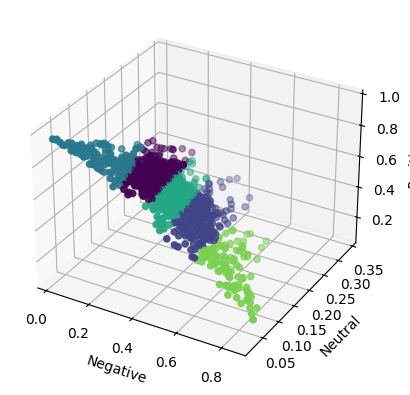

In [211]:
get_cluster_plot(senti, "cluster")

## DB-Scan Clustering

In [212]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# DataFrame df annehmen, der die entsprechenden Spalten enthält
features = senti[['negative', 'neutral', 'positive']]

# Skalieren der Daten
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [228]:
# DBSCAN-Clustering
dbscan = DBSCAN(eps=0.20, min_samples=5)  # eps und min_samples nach Bedarf anpassen
clusters = dbscan.fit_predict(features_scaled)

# Hinzufügen der Cluster-Labels zum ursprünglichen DataFrame
senti['cluster-db'] = clusters
append_cluster_color(senti, 'cluster-db')

In [214]:
print(senti['cluster-db'].value_counts())

cluster-db
 0     1360
-1      196
 1       67
 4       43
 2       21
 8       11
 3        9
 9        7
 5        6
 7        6
 10       5
 6        5
 12       5
 11       5
Name: count, dtype: int64


In [229]:
senti['color_cluster-db'].nunique()

14

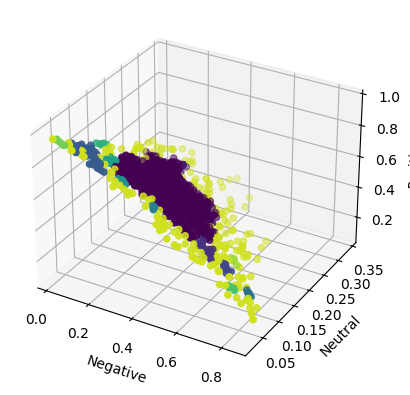

In [230]:
get_cluster_plot(senti, "cluster-db")

## Hierarchical Clustering 

In [70]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
# DataFrame df annehmen, der die entsprechenden Spalten enthält
features = senti[['negative', 'neutral', 'positive']]

# Skalieren der Daten
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [231]:
# Hierarchical Clustering
cluster = AgglomerativeClustering(n_clusters=8, linkage='ward')
# Anwenden des Modells
cluster_labels = cluster.fit_predict(features_scaled)

# Hinzufügen der Cluster-Labels zum DataFrame
senti['cluster-h'] = cluster_labels
append_cluster_color(senti, 'cluster-h')


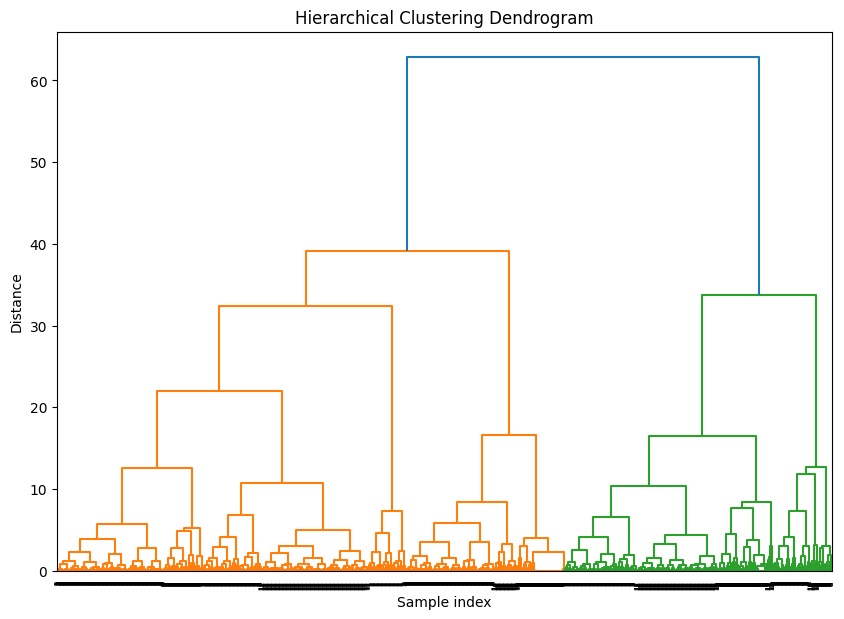

In [78]:
# Erstellen eines Linkage-Matrix
linked = linkage(features_scaled, 'ward')

# Dendrogramm zeichnen
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=cluster_labels, distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [85]:
senti['cluster-h'].value_counts()

cluster-h
5    372
1    346
2    329
7    254
0    133
3    124
6    104
4     84
Name: count, dtype: int64

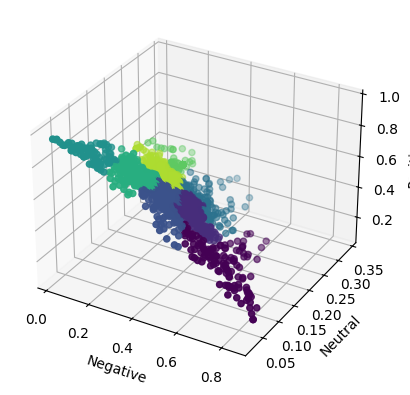

In [232]:
get_cluster_plot(senti, "cluster-h")


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Erstellen einer neuen Figur
fig = plt.figure(figsize=(15, 10))

# Hinzufügen eines 3D-Subplots
ax = fig.add_subplot(111, projection='3d')

# Daten für jede Achse
df = senti.loc[senti["cluster"]==2]
x = df["negative"]
y = df["neutral"]
z = df["positive"]
color = df["color"]

# Plotten der Daten
ax.scatter3D(x, y, z, c=color)

# Beschriftung der Achsen
ax.set_xlabel('negative')
ax.set_ylabel('neutral')
ax.set_zlabel('positive')

# Anzeigen des Plots
plt.show()

In [117]:
import json

with open("../graph_network/scc_dict.json") as json_file:
    scc_dict = json.load(json_file)
senti['scc_id'] = senti['url'].map(scc_dict)
append_cluster_color(senti, 'scc_id')

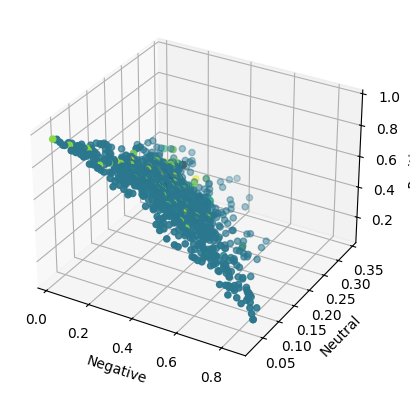

In [237]:
get_cluster_plot(senti, "scc_id")


In [128]:
import json
with open("../graph_network/wcc_dict.json") as json_file:
    wcc_dict = json.load(json_file)
senti['wcc_id'] = senti['url'].map(wcc_dict)
append_cluster_color(senti, 'wcc_id')

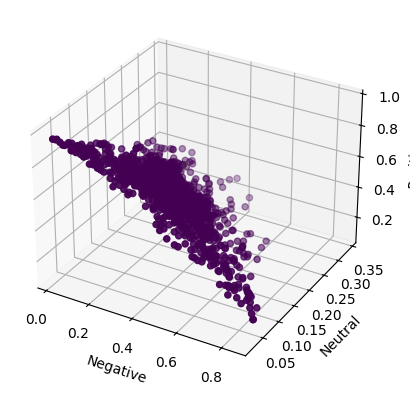

In [239]:
get_cluster_plot(senti, "wcc_id")

In [130]:
import json
with open("../graph_network/louvain_communities_dict.json") as json_file:
    louvain_communities_dict = json.load(json_file)
senti['louvain_id'] = senti['url'].map(louvain_communities_dict)
append_cluster_color(senti, 'louvain_id')

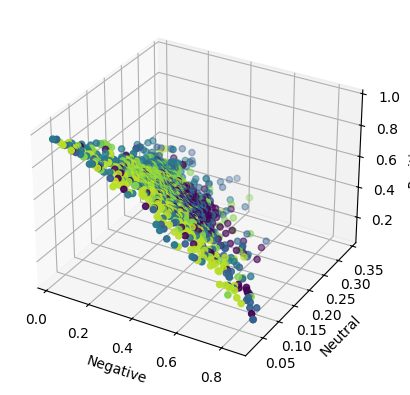

In [240]:
get_cluster_plot(senti, "louvain_id")

## Word-Clouds

In [59]:
senti['word_count'] = senti['text'].apply(lambda x: len(str(x).split()))

In [45]:
def clean_url(url):
    if 'mobiliar.ch' in url:
        return url.replace('https://www.mobiliar.ch', '').lstrip('/').replace('/', ', ')
        # if "die-mobiliar" in url:
        #     return url.replace('die-mobiliar', '').lstrip('/').replace('/', ', ')
    return url.replace('/', ', ')

# Anwenden der Funktion auf die 'url'-Spalte und Erstellen einer neuen Spalte
senti['cleaned_url'] = senti['url'].apply(clean_url)

In [59]:
bad["cleaned_url"].iloc[0]

'versicherungen-und-vorsorge, services, mobiliar-digital, das-meine-mobiliar-kundenportal'

In [90]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [109]:
text = senti.drop_duplicates(subset=['text', "negative", "neutral", "positive"]).sort_values("positive", ascending=False)[:25]["text"].str.cat(sep=" ")

# text = senti.loc[senti["cluster"]==2]["text"].str.cat(sep=" ")
print ("There are {} words.".format(len(text)))

There are 22686 words.


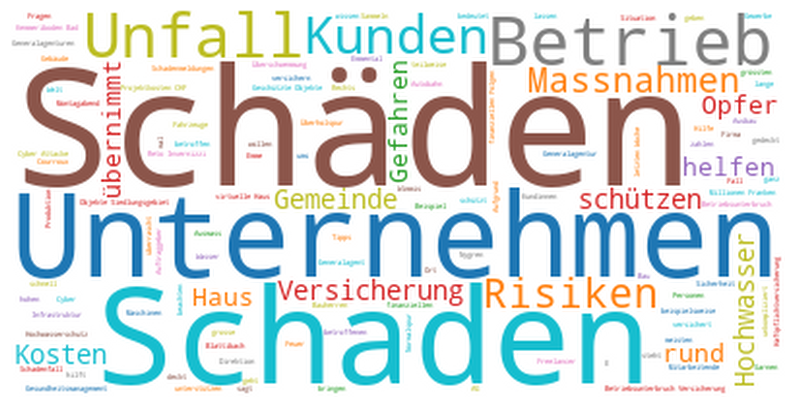

In [108]:
stop_words = []
with open("../sentiment-analyser/german_stopwords.txt", 'r', encoding='utf-8') as file:
    content = file.read()
    stop_words = [word.strip() for word in content.split(',')]

stopwords = set(STOPWORDS)
stopwords.update(stop_words + ["mobiliar", "z.B.", "jQuery", "getScript", "hasJquery", "function", "undefined", "letTimeout"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="tab10").generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis("off")
plt.show()

In [32]:
# Save the image in the img folder:
wordcloud.to_file("wordcloud_cluster_bad.png")

In [ ]:
senti.drop_duplicates(subset=['text', "negative", "neutral", "positive"]).sort_values("negative", ascending=False)[:10]#["url"]


In [ ]:
pd.set_option('display.max_colwidth', None) #.loc[senti["cluster"]==3]
senti.sort_values("negative", ascending=False)[:10]#["url"]



## Cluster Analysis

In [89]:
cluster = senti.groupby("cluster")
cluster.describe().head()

negative                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0          419.0  0.234782  0.035903  0.131020  0.212159  0.240448  0.260305   
1          503.0  0.426442  0.043476  0.333699  0.393224  0.417011  0.454205   
2          119.0  0.640105  0.079792  0.481766  0.577563  0.622331  0.698860   
3           87.0  0.111851  0.040744  0.019911  0.082178  0.111310  0.146752   
4          618.0  0.303257  0.038443  0.185334  0.272953  0.301861  0.333188   

                  neutral            ... avg_positive          cluster-h  \
              max   count      mean  ...          75%      max     count   
cluster                              ...                                   
0        0.312941   419.0  0.133388  ...     0.567050  0.71896     419.0   
1        0.549379   503.0  0.161479  ...     0.552698  0.68492     503.0   
2        0.844019   119.0  0.127750  ...     0.551390  0.67849     119.0   
3        0.193840    87.0  0.070634  ...     0.608385  0.69176      87.0   
4        0.395983   618.0  0.172159  ...     0.561790  0.71418     618.0   

                                                      
             mean       std  min  25%  50%  75%  max  
cluster                                               
0        5.241050  0.878578  2.0  5.0  5.0  5.0  7.0  
1        1.441352  0.851551  0.0  1.0  1.0  2.0  3.0  
2        0.201681  0.683707  0.0  0.0  0.0  0.0  3.0  
3        4.034483  0.183523  4.0  4.0  4.0  4.0  5.0  
4        4.333333  2.308231  1.0  2.0  5.0  7.0  7.0  

[5 rows x 72 columns]

In [191]:
get_mean_coefficients_per_cluster(senti, "cluster-h")

Cluster Nr. 0; Total Pages in Cluster: 133
avg negative: 0.6238
avg neutral: 0.11782
avg positive: 0.25838

Cluster Nr. 1; Total Pages in Cluster: 346
avg negative: 0.42168
avg neutral: 0.16093
avg positive: 0.41739

Cluster Nr. 2; Total Pages in Cluster: 329
avg negative: 0.34591
avg neutral: 0.13255
avg positive: 0.52153

Cluster Nr. 3; Total Pages in Cluster: 124
avg negative: 0.40909
avg neutral: 0.21362
avg positive: 0.37729

Cluster Nr. 4; Total Pages in Cluster: 84
avg negative: 0.10987
avg neutral: 0.06956
avg positive: 0.82057

Cluster Nr. 5; Total Pages in Cluster: 372
avg negative: 0.24197
avg neutral: 0.12532
avg positive: 0.63272

Cluster Nr. 6; Total Pages in Cluster: 104
avg negative: 0.24664
avg neutral: 0.24034
avg positive: 0.51302

Cluster Nr. 7; Total Pages in Cluster: 254
avg negative: 0.26732
avg neutral: 0.18091
avg positive: 0.55177



In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Erstellen eines TfidfVectorizer-Objekts
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('german'))

# Anpassen des Vectorizers an die Textdaten und Umwandlung der Textdaten
tfidf_matrix = vectorizer.fit_transform(senti['text'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romanroth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
from sklearn.cluster import KMeans

# Erstellen eines KMeans-Modells
num_clusters = 5  # Sie können die Anzahl der Cluster basierend auf Ihrer Analyse festlegen
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Anpassen des Modells an die TF-IDF-Matrix
kmeans.fit(tfidf_matrix)

# Zuordnen der Dokumente zu Clustern
clusters = kmeans.labels_
senti['cluster'] = clusters


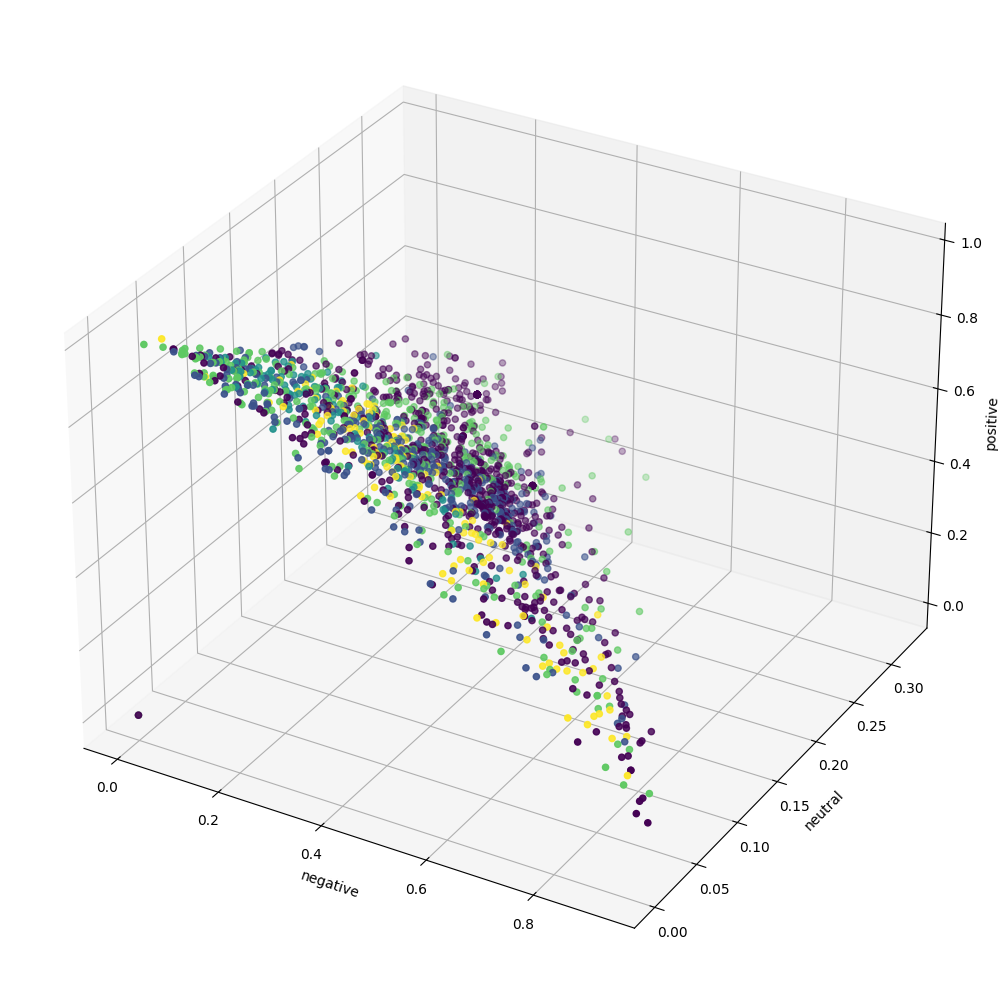

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Erstellen einer neuen Figur
fig = plt.figure(figsize=(15, 10))

# Hinzufügen eines 3D-Subplots
ax = fig.add_subplot(111, projection='3d')

# Daten für jede Achse
x = senti["negative"]
y = senti["neutral"]
z = senti["positive"]
color = senti["cluster"]

# Plotten der Daten
ax.scatter3D(x, y, z, c=color, cmap='viridis')

# Beschriftung der Achsen
ax.set_xlabel('negative')
ax.set_ylabel('neutral')
ax.set_zlabel('positive')

# Anzeigen des Plots
plt.show()


In [ ]:
# XY-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
plt.title('2D Plot - XY Plane')
plt.show()

# XZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, z, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Positive')
plt.title('2D Plot - XZ Plane')
plt.show()

# YZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y, z, c=color)
ax.set_xlabel('Neutral')
ax.set_ylabel('Positive')
plt.title('2D Plot - YZ Plane')
plt.show()


In [ ]:
bins = np.arange(0, 1.05, 0.05) 
hist, bin_edges = np.histogram(senti['positive'], bins=bins)

# Histogramm anzeigen
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.xlabel('Coeficent')
plt.ylabel('sum of values')
plt.title('Distribution of positive coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(senti['neutral'], bins=bins)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.title('Distribution of neutral coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(senti['negative'], bins=bins)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.title('Distribution of negative coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

# Boxplot erstellen
plt.figure(figsize=(6, 4))
# plt.boxplot(senti['negative'], vert=False)
plt.boxplot([senti['negative'], senti['neutral'], senti['positive']], labels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Negative Rating')
plt.title('Boxplot der negativen Bewertungen')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist([senti['negative'], senti['neutral'], senti['positive']], bins=bins, stacked=True, label=['Negative', 'Neutral', 'Positive'], color=['red', 'yellow', 'green'], alpha=0.5)
plt.xlabel('Bewertungswerte')
plt.ylabel('Häufigkeit')
plt.title('Gestapelte Histogramme der Bewertungen')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
senti = get_mean_sentiment_coefficients_of_neighbours(senti)

In [63]:
senti.loc[senti["cluster"]==2].corr(method='pearson', numeric_only = True)

,negative,neutral,positive,cluster,cluster-db,word_count,avg_negative,avg_neutral,avg_positive
negative,1.000000,-0.517008,-0.808650,NaN,-0.230555,-0.030857,-0.144244,0.058118,0.109368
neutral,-0.517008,1.000000,-0.085486,NaN,-0.112874,0.019077,0.090843,0.295644,-0.250754
positive,-0.808650,-0.085486,1.000000,NaN,0.345935,0.022806,0.105210,-0.267848,0.043646
cluster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster-db,-0.230555,-0.112874,0.345935,NaN,1.000000,-0.047206,-0.051173,-0.114916,0.112991
word_count,-0.030857,0.019077,0.022806,NaN,-0.047206,1.000000,-0.084586,0.415290,-0.144560
avg_negative,-0.144244,0.090843,0.105210,NaN,-0.051173,-0.084586,1.000000,-0.240340,-0.847138
avg_neutral,0.058118,0.295644,-0.267848,NaN,-0.114916,0.415290,-0.240340,1.000000,-0.312197
avg_positive,0.109368,-0.250754,0.043646,NaN,0.112991,-0.144560,-0.847138,-0.312197,1.000000


In [140]:
senti.corr(method='pearson', numeric_only = True)


,negative,neutral,positive,cluster,cluster-db,word_count,avg_negative,avg_neutral,avg_positive,cluster-h,scc_id,wcc_id,louvain_id
negative,1.000000,0.023083,-0.943124,-0.056955,-0.125000,0.040326,0.084523,-0.065424,-0.035171,-0.721265,-0.064162,-0.070544,-0.223734
neutral,0.023083,1.000000,-0.354122,0.222403,-0.286193,0.080930,-0.052226,0.242241,-0.080587,0.246753,0.018132,0.228675,-0.285252
positive,-0.943124,-0.354122,1.000000,-0.020677,0.212099,-0.064634,-0.062588,-0.012845,0.057117,0.592653,0.053991,-0.010051,0.304146
cluster,-0.056955,0.222403,-0.020677,1.000000,0.113137,0.002198,-0.034082,0.091553,-0.018863,0.098846,0.046897,0.135842,-0.033979
cluster-db,-0.125000,-0.286193,0.212099,0.113137,1.000000,-0.132832,-0.053395,-0.084243,0.085901,-0.016404,0.005136,0.047375,0.028744
word_count,0.040326,0.080930,-0.064634,0.002198,-0.132832,1.000000,0.030964,0.170702,-0.111608,-0.104166,0.021542,-0.098398,0.005097
avg_negative,0.084523,-0.052226,-0.062588,-0.034082,-0.053395,0.030964,1.000000,0.108163,-0.863637,-0.073391,-0.130628,NaN,0.119353
avg_neutral,-0.065424,0.242241,-0.012845,0.091553,-0.084243,0.170702,0.108163,1.000000,-0.594570,0.104228,0.013758,NaN,-0.125874
avg_positive,-0.035171,-0.080587,0.057117,-0.018863,0.085901,-0.111608,-0.863637,-0.594570,1.000000,0.006493,0.098681,NaN,-0.032739
cluster-h,-0.721265,0.246753,0.592653,0.098846,-0.016404,-0.104166,-0.073391,0.104228,0.006493,1.000000,0.050845,0.125226,0.202391


<Figure size 1000x800 with 0 Axes>

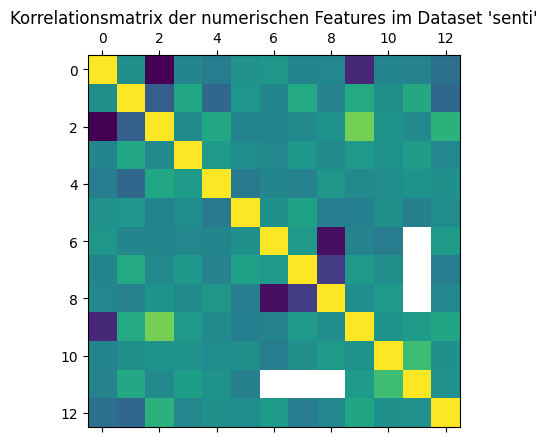

In [143]:

import matplotlib.pyplot as plt
# Heatmap der Korrelationsmatrix erstellen
plt.figure(figsize=(10, 8))
plt.matshow(senti.corr(method='pearson', numeric_only = True))
plt.title("Korrelationsmatrix der numerischen Features im Dataset 'senti'")
plt.show()
